In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [171]:
training_data = pd.read_csv('../assets/input/train.csv')
testing_data = pd.read_csv('../assets/input/test.csv')
weather = pd.read_csv('../assets/input/weather.csv')
spray = pd.read_csv('../assets/input/spray.csv')

## Climate Cleaning

In [3]:
# Calculate and fill in Tavg using half-up rounding to maintain parity with existing data.
weather['Tavg'] = np.ceil(((weather['Tmax'] + weather['Tmin']) / 2) - .4999).astype(int)

In [4]:
# If Tavg - Depart is the expected temperature for that day, that calculation can
# be used to fill in missing values for Station 2 using data from Station 1.

# In order to run the following list on the Depart series, it is necessary to
# homogenize the datatypes. By replacing the elements that keep it an object
# and casting it as a series of ints, we enable manipulation of the numerics.
weather['Depart'].replace('M', None, inplace=True)
weather['Depart'] = weather['Depart'].astype(int)

# Replace incorrect values for Depart for Station 2 with properly calculated
# values from Station 1 on the same days.
i = 1
while i < len(weather):
    normal = weather['Tavg'].iloc[i - 1] - weather['Depart'].iloc[i - 1]
    weather['Depart'].iloc[i] = weather['Tavg'].iloc[i] - normal
    i += 2
    
# Think of the RAM and dealloc!
del(normal, i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# WetBulb doesn't have a clear way to calculate missing values, however the
# discrepencies between Station 1 and 2's measurements are within 2 degrees and
# often coincide directly. Since we are already resigned the fact that models
# are not perfect emulations of reality, I don't believe it to be unfair to
# suggest replacing the four missing values with the counterpart station's
# measurement.

# Just as with Depart, it is necessary to first homogenize the datatype of the
# series in order to manipulate it. First we need the index values of the cells
# in question.
ixlist = list(weather[weather['WetBulb'] == 'M'].index.values)

# Replace 'M's with None and typecast as int.
weather['WetBulb'].replace('M', None, inplace=True)
weather['WetBulb'] = weather['WetBulb'].astype(int)

# Using mod, it is easy to ensure the data is being copied from the correct day.
for i in ixlist:
    if i % 2 == 0:
        weather['WetBulb'].iloc[i] = weather['WetBulb'].iloc[i + 1]
    else:
        weather['WetBulb'].iloc[i] = weather['WetBulb'].iloc[i - 1]

# Liberate your memory!
del(ixlist, i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Heat and Cool are easily computable given that the base value is given at 65.
# First things first, replace and typecast:
weather['Heat'].replace('M', None, inplace=True)
weather['Cool'].replace('M', None, inplace=True)
weather['Heat'] = weather['Heat'].astype(int)
weather['Cool'] = weather['Cool'].astype(int)

# So it turns out that going through all the rows is more time consuming than
# anticipated. If you made the mistake of running this cell, go ahead and grab
# yourself a coffee.
for i in range(len(weather)):
    if weather['Tavg'].iloc[i] >= 65:
        weather['Heat'].iloc[i] = 0
        weather['Cool'].iloc[i] = weather['Tavg'].iloc[i] - 65
    else:
        weather['Cool'].iloc[i] = 0
        weather['Heat'].iloc[i] = 65 - weather['Tavg'].iloc[i]

# Leave no RAM unnecessarily allocated
del(i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# Sunrise and sunset are caluclated rather than observed and only missing for
# one station. Its just a simple transcription job. Replace and typecast:
weather['Sunrise'].replace('-', None, inplace = True)
weather['Sunset'].replace('-', None, inplace = True)
weather['Sunrise'] = weather['Sunrise'].astype(int)
weather['Sunset'] = weather['Sunset'].astype(int)

# Much like with Depart, we merely need to alter every other row
i = 1
while i < len(weather):
    weather['Sunrise'].iloc[i] = weather['Sunrise'].iloc[i - 1]
    weather['Sunset'].iloc[i] = weather['Sunset'].iloc[i - 1]
    i += 2

# Every little bit helps
del(i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# All depth and water values are 0. Since there is no overwriting at play here,
# there is no need to replace and typecast before reassigning.
weather['Depth'] = 0
weather['Water1'] = 0

In [10]:
# So far all the replacements made have been justifiable given the data. In the
# case of Snowfall, slight liberties will be taken. Namely, 'T', for 'trace'
# will be replaced with 0.05 which is half the minimum quantified value in
# order to preserve the observation. Station 2 will have its values set to
# mirror Station 1. To start, whitespaces must be stripped from the set:
weather['SnowFall'] = weather['SnowFall'].str.strip()

#Replace and typecast
weather['SnowFall'].replace('T', .05, inplace=True)
weather['SnowFall'].replace('M', None, inplace=True)
weather['SnowFall'] = weather['SnowFall'].astype(float)

# Mirror Station 1 values for Station 2
i = 1
while i < len(weather):
    weather['SnowFall'].iloc[i] = weather['SnowFall'].iloc[i - 1]
    i += 2

# Take care of NaNs
weather['SnowFall'].fillna(0.0, inplace=True)

# Dust to dust
del(i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
# Most of the non-numeric values in the PrecipTotal category are 'T' values,
# which we can again replace with half the minimum quantity to preserve the
# measurement. The two 'M' values, can be set to 0 to mirror the other stations
# measurement for that day.
weather['PrecipTotal'] = weather['PrecipTotal'].str.strip()
weather['PrecipTotal'].replace('T', .05, inplace=True)
weather['PrecipTotal'].replace('M', 0.0, inplace=True)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [46]:
# StnPressure puts us in an awkward spot. On average, Station 1's pressure is
# .05 to .10 lower than Station 2's, but as far as I know we do not have enough
# information to calculate it precisely. Furthermore on 8/10/13, both stations
# are missing their measurements. To fill in the the 'M' values, we can add or
# subtract in the given range from the other stations value to approximate a
# likely value. For the other 'M' values, using a boolean mask I found what
# other days had similar conditions and will base my numbers off of those.

# Replace and typecast
weather['StnPressure'].replace('M', None, inplace=True)
weather['StnPressure'] = weather['StnPressure'].astype(float)

weather['StnPressure'].iloc[87] = weather['StnPressure'].iloc[86] + .06
weather['StnPressure'].iloc[848] = weather['StnPressure'].iloc[849] - .07
# Value based on the day with the most similar conditions
weather['StnPressure'].iloc[2411] = weather['StnPressure'].iloc[2763]
weather['StnPressure'].iloc[2410] = weather['StnPressure'].iloc[2411] - .06

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
# SeaLevel measurements tend to vary between stations by +/- .02. None of the
# missing values occur in contiguous rows, so we can simply set missing values
# equal to the other station measurement which will be good enough.

# Generate list of index values where SeaLevel measurements are missing
ixlist = list(weather[weather['SeaLevel'] == 'M'].index.values)

# Replace 'M's with None and typecast as float.
weather['SeaLevel'].replace('M', None, inplace=True)
weather['SeaLevel'] = weather['SeaLevel'].astype(float)

# Using mod, as we did with WetBulb
for i in ixlist:
    if i % 2 == 0:
        weather['SeaLevel'].iloc[i] = weather['SeaLevel'].iloc[i + 1]
    else:
        weather['SeaLevel'].iloc[i] = weather['SeaLevel'].iloc[i - 1]

# Guillotine the bourgeoisie RAM hoarders
del(ixlist, i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
# The variance between station measurements of AvgSpeed can be quite large.
# On the plus side, there are only three missing values in this category. To
# generate predictions for these missing values, we can measure the difference
# in ResultSpeed between the two stations and apply that difference to the
# measurement of AvgSpeed and call it good enough.

ixlist = list(weather[weather['AvgSpeed'] == 'M'].index.values)

# Replace 'M's with None and typecast as float.
weather['AvgSpeed'].replace('M', None, inplace=True)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

# All missing values are for Station 2 measurements.
for i in ixlist:
    diff = weather['ResultSpeed'].iloc[i - 1] - weather['ResultSpeed'].iloc[i]
    weather['AvgSpeed'].iloc[i] = weather['AvgSpeed'].iloc[i - 1] - diff

# The new Purge film continues the trend of being less compelling than the last
del(ixlist, diff, i)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [150]:
# Mapping the codes in CodeSum into binary categorical columns.
weather['Thunderstorm'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'TS')).any(1), '1', '0')
weather['Rain'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'RA')).any(1), '1', '0')
weather['Drizzle'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'DZ')).any(1), '1', '0')
weather['Snow'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'SN')).any(1), '1', '0')
weather['Fog'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'FG')).any(1), '1', '0')
weather['Mist'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'BR')).any(1), '1', '0')
weather['Haze'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'HZ')).any(1), '1', '0')
weather['Smoke'] = np.where(weather[['CodeSum']].apply(
    lambda x: x.str.contains(r'FU')).any(1), '1', '0')

# Typecast newly created encoded columns as numeric
weather[['Thunderstorm', 'Rain', 'Drizzle', 'Snow', 'Fog', 'Mist', 'Haze',
         'Smoke']] = weather[['Thunderstorm', 'Rain', 'Drizzle', 'Snow', 'Fog',
                              'Mist', 'Haze', 'Smoke']].apply(pd.to_numeric)

In [443]:
# Export to csv
weather.to_csv('../assets/input/clean_weather.csv', index=False)

In [477]:
# Import clean set from csv
weather = pd.read_csv('../assets/input/clean_weather.csv')

In [212]:
pd.set_option('display.max_columns',30)
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
0,1,2007-05-01,83,50,67,14,51,56,0,2,448,1849,,0,0,0.0,0.00,29.10,29.82,1.7,27,9.2,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,15,51,57,0,3,448,1849,,0,0,0.0,0.00,29.18,29.82,2.7,25,9.6,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47,14,0,447,1850,BR,0,0,0.0,0.00,29.38,30.09,13.0,4,13.4,0,0,0,0,0,1,0,0
3,2,2007-05-02,60,43,52,-2,42,47,13,0,447,1850,BR HZ,0,0,0.0,0.00,29.44,30.08,13.3,2,13.4,0,0,0,0,0,1,1,0
4,1,2007-05-03,66,46,56,2,40,48,9,0,446,1851,,0,0,0.0,0.00,29.39,30.12,11.7,7,11.9,0,0,0,0,0,0,0,0
5,2,2007-05-03,67,48,58,4,40,50,7,0,446,1851,HZ,0,0,0.0,0.00,29.46,30.12,12.9,6,13.2,0,0,0,0,0,0,1,0
6,1,2007-05-04,66,49,58,4,41,50,7,0,444,1852,RA,0,0,0.0,0.05,29.31,30.05,10.4,8,10.8,0,1,0,0,0,0,0,0
7,2,2007-05-04,78,51,65,11,42,50,0,0,444,1852,,0,0,0.0,0.00,29.36,30.04,10.1,7,10.4,0,0,0,0,0,0,0,0
8,1,2007-05-05,66,53,60,5,38,49,5,0,443,1853,,0,0,0.0,0.05,29.40,30.10,11.7,7,12.0,0,0,0,0,0,0,0,0
9,2,2007-05-05,66,54,60,5,39,50,5,0,443,1853,,0,0,0.0,0.05,29.46,30.09,11.2,7,11.5,0,0,0,0,0,0,0,0


## Average Temperatures by Month and Year

In [ ]:
# Import clean set from csv
weather = pd.read_csv('../assets/input/clean_weather.csv')

In [478]:
# Initialize avg temperature dataframe
temp_avgs = pd.DataFrame(columns=['May', 'June', 'July', 'August', 'September',
                                  'October', '6 Month Avg'],
                         index = [2006, 2007, 2008, 2009, 2010, 2011, 2012,
                                  2013, 2014])

# Manually input based on historic weather data from WU at zipcode 60647 (KMDW)
temp_avgs.loc[2006] = [61., 69., 78., 75., 64., 51., 66.3333333]
# For the rest, we will use our existing data. If I knew a better way to
# automate the process I would do that.
temp_avgs.loc[2007] = [
    weather.loc[weather['Date'].str.contains(r'2007-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2007-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2007-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2007-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2007-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2007-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2007-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2007'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2007').sum()
]
temp_avgs.loc[2008] = [
    weather.loc[weather['Date'].str.contains(r'2008-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2008-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2008-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2008-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2008-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2008-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2008-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2008'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2008').sum()
]
temp_avgs.loc[2009] = [
    weather.loc[weather['Date'].str.contains(r'2009-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2009-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2009-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2009-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2009-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2009-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2009-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2009'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2009').sum()
]
temp_avgs.loc[2010] = [
    weather.loc[weather['Date'].str.contains(r'2010-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2010-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2010-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2010-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2010-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2010-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2010-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2010'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2010').sum()
]
temp_avgs.loc[2011] = [
    weather.loc[weather['Date'].str.contains(r'2011-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2011-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2011-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2011-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2011-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2011-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2011-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2011'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2011').sum()
]
temp_avgs.loc[2012] = [
    weather.loc[weather['Date'].str.contains(r'2012-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2012-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2012-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2012-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2012-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2012-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2012-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2012'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2012').sum()
]
temp_avgs.loc[2013] = [
    weather.loc[weather['Date'].str.contains(r'2013-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2013-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2013-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2013-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2013-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2013-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2013-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2013'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2013').sum()
]
temp_avgs.loc[2014] = [
    weather.loc[weather['Date'].str.contains(r'2014-05'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-05').sum(),
    weather.loc[weather['Date'].str.contains(r'2014-06'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-06').sum(),
    weather.loc[weather['Date'].str.contains(r'2014-07'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-07').sum(),
    weather.loc[weather['Date'].str.contains(r'2014-08'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-08').sum(),
    weather.loc[weather['Date'].str.contains(r'2014-09'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-09').sum(),
    weather.loc[weather['Date'].str.contains(r'2014-10'),
                'Tavg'].sum() / weather['Date'].str.contains(r'2014-10').sum(),
    weather.loc[weather['Date'].str.contains(r'2014'),
            'Tavg'].sum() / weather['Date'].str.contains(r'2014').sum()
]

In [ ]:
# Export to csv
temp_avgs.to_csv('../assets/input/temp_avgs.csv')

In [381]:
# Import from csv
temp_avgs = pd.read_csv('../assets/input/temp_avgs.csv', index_col='Unnamed: 0')

## Generating Mergeable DataFrame of Weather

In [480]:
# The original plan to determine the lat/long for each station by cross-referencing
# NOAA data for all Chicago statoins and applying the most proximate weather
# data to each train and test observation has fallen through due to emergency
# maintenance on NOAA's end. As a result, we must fall back on relying on 
# averaged values between station observations.

# Copying numeric elements of the weather dataframe
weather_avgd = weather.drop(columns=['Station', 'Date', 'CodeSum'])

# Replacing values with averages
i1 = 0
i2 = 0
while i2 < len(weather_avgd):
    weather_avgd.iloc[i1] = (weather_avgd.iloc[i2] + 
                             weather_avgd.iloc[i2 + 1]) / 2
    i1 += 1
    i2 += 2

# Free memory
del(i1, i2)

# Drop superfluous rows
weather_avgd = weather_avgd[:-1472]

In [481]:
# Add back dates column
date_series = pd.Series(weather['Date'].unique(), name='Date')
weather_avgd = pd.concat([date_series, weather_avgd], axis=1)

del(date_series)

In [482]:
# It's not clear whether it would be better to homogenize the boolean columns
# or to just leave the partial values where there was discrepent codes by
# station. If time permits, it may be worth checking both out. This cell
# restores the boolean nature of the columns as they were in the original
# weather dataframe

#featlist = ['Thunderstorm', 'Rain', 'Drizzle', 'Snow', 'Fog', 'Mist', 'Haze', 'Smoke']
#
#for feature in featlist:
#    weather_avgd[feature] = np.ceil(weather_avgd[feature]).astype(int)
#    
#del(featlist)

In [483]:
# To illustrate the point, note how parity is annihilated
print('original weather:', '\n', weather['Thunderstorm'].value_counts() / 2,
     '\n')
print('avgd weather:', '\n', weather_avgd['Thunderstorm'].value_counts())

original weather: 
 0    1295.5
1     176.5
Name: Thunderstorm, dtype: float64 

avgd weather: 
 0.0    1241
1.0     122
0.5     109
Name: Thunderstorm, dtype: int64


In [484]:
# Export to csv
weather_avgd.to_csv('../assets/input/weather_averaged.csv', index=False)

## Additional Feature Engineering

In [475]:
# Import averaged set from csv
weather = pd.read_csv('../assets/input/weather_averaged.csv')

In [485]:
(weather['AvgSpeed'] > 10.0).value_counts() # windy

False    2110
True      834
Name: AvgSpeed, dtype: int64

In [ ]:
# if 05-01, set counter to 30
weather['']

In [476]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
0,2007-05-01,83.5,51.0,67.5,14.5,51.0,56.5,0.0,2.5,448.0,1849.0,0.0,0.0,0.0,0.000,29.140,29.820,2.20,26.0,9.40,0,0,0,0,0,0,0,0
1,2007-05-02,59.5,42.5,51.5,-2.5,42.0,47.0,13.5,0.0,447.0,1850.0,0.0,0.0,0.0,0.000,29.410,30.085,13.15,3.0,13.40,0,0,0,0,0,1,1,0
2,2007-05-03,66.5,47.0,57.0,3.0,40.0,49.0,8.0,0.0,446.0,1851.0,0.0,0.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,0,0,0,0,0,0,1,0
3,2007-05-04,72.0,50.0,61.5,7.5,41.5,50.0,3.5,0.0,444.0,1852.0,0.0,0.0,0.0,0.025,29.335,30.045,10.25,7.5,10.60,0,1,0,0,0,0,0,0
4,2007-05-05,66.0,53.5,60.0,5.0,38.5,49.5,5.0,0.0,443.0,1853.0,0.0,0.0,0.0,0.050,29.430,30.095,11.45,7.0,11.75,0,0,0,0,0,0,0,0


In [451]:
df = pd.read_csv('../assets/input/with_coefs.csv')

In [452]:
df.drop(columns=['Unnamed: 0', 'address', 'loc'], inplace=True)
df.rename(index=str, columns={'date':'Date'}, inplace=True)

In [454]:
df = pd.merge(df, weather, on='Date')

In [455]:
pd.set_option('display.max_columns', 34)
pd.set_option('display.max_rows', 34)
df

,Date,lat,long,count,wnv,utc,loc_coef,time_coef,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
0,2007-05-29,41.954690,-87.800991,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
1,2007-05-29,41.954690,-87.800991,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
2,2007-05-29,41.994991,-87.769279,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
3,2007-05-29,41.974089,-87.824812,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
4,2007-05-29,41.974089,-87.824812,4,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
5,2007-05-29,41.921600,-87.666455,2,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
6,2007-05-29,41.891118,-87.654491,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
7,2007-05-29,41.867108,-87.654224,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
8,2007-05-29,41.867108,-87.654224,2,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0
9,2007-05-29,41.896282,-87.655232,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.10,5.80,17.0,6.95,0,0,0,0,0,1,1,0


In [458]:
scaled = df.drop(columns=['Date', 'loc_coef', 'time_coef'])

In [460]:
ss = StandardScaler()
scaled = ss.fit_transform(scaled)

In [462]:
scaled = pd.DataFrame(scaled)

In [464]:
df.head()

,Date,lat,long,count,wnv,utc,loc_coef,time_coef,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
0,2007-05-29,41.954690,-87.800991,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.1,5.8,17.0,6.95,0,0,0,0,0,1,1,0
1,2007-05-29,41.954690,-87.800991,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.1,5.8,17.0,6.95,0,0,0,0,0,1,1,0
2,2007-05-29,41.994991,-87.769279,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.1,5.8,17.0,6.95,0,0,0,0,0,1,1,0
3,2007-05-29,41.974089,-87.824812,1,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.1,5.8,17.0,6.95,0,0,0,0,0,1,1,0
4,2007-05-29,41.974089,-87.824812,4,0,1180422000,NaN,NaN,88.0,62.5,75.5,11.5,58.5,65.5,0.0,10.5,421.0,...,0.0,0.0,0.0,0.0,29.415,30.1,5.8,17.0,6.95,0,0,0,0,0,1,1,0


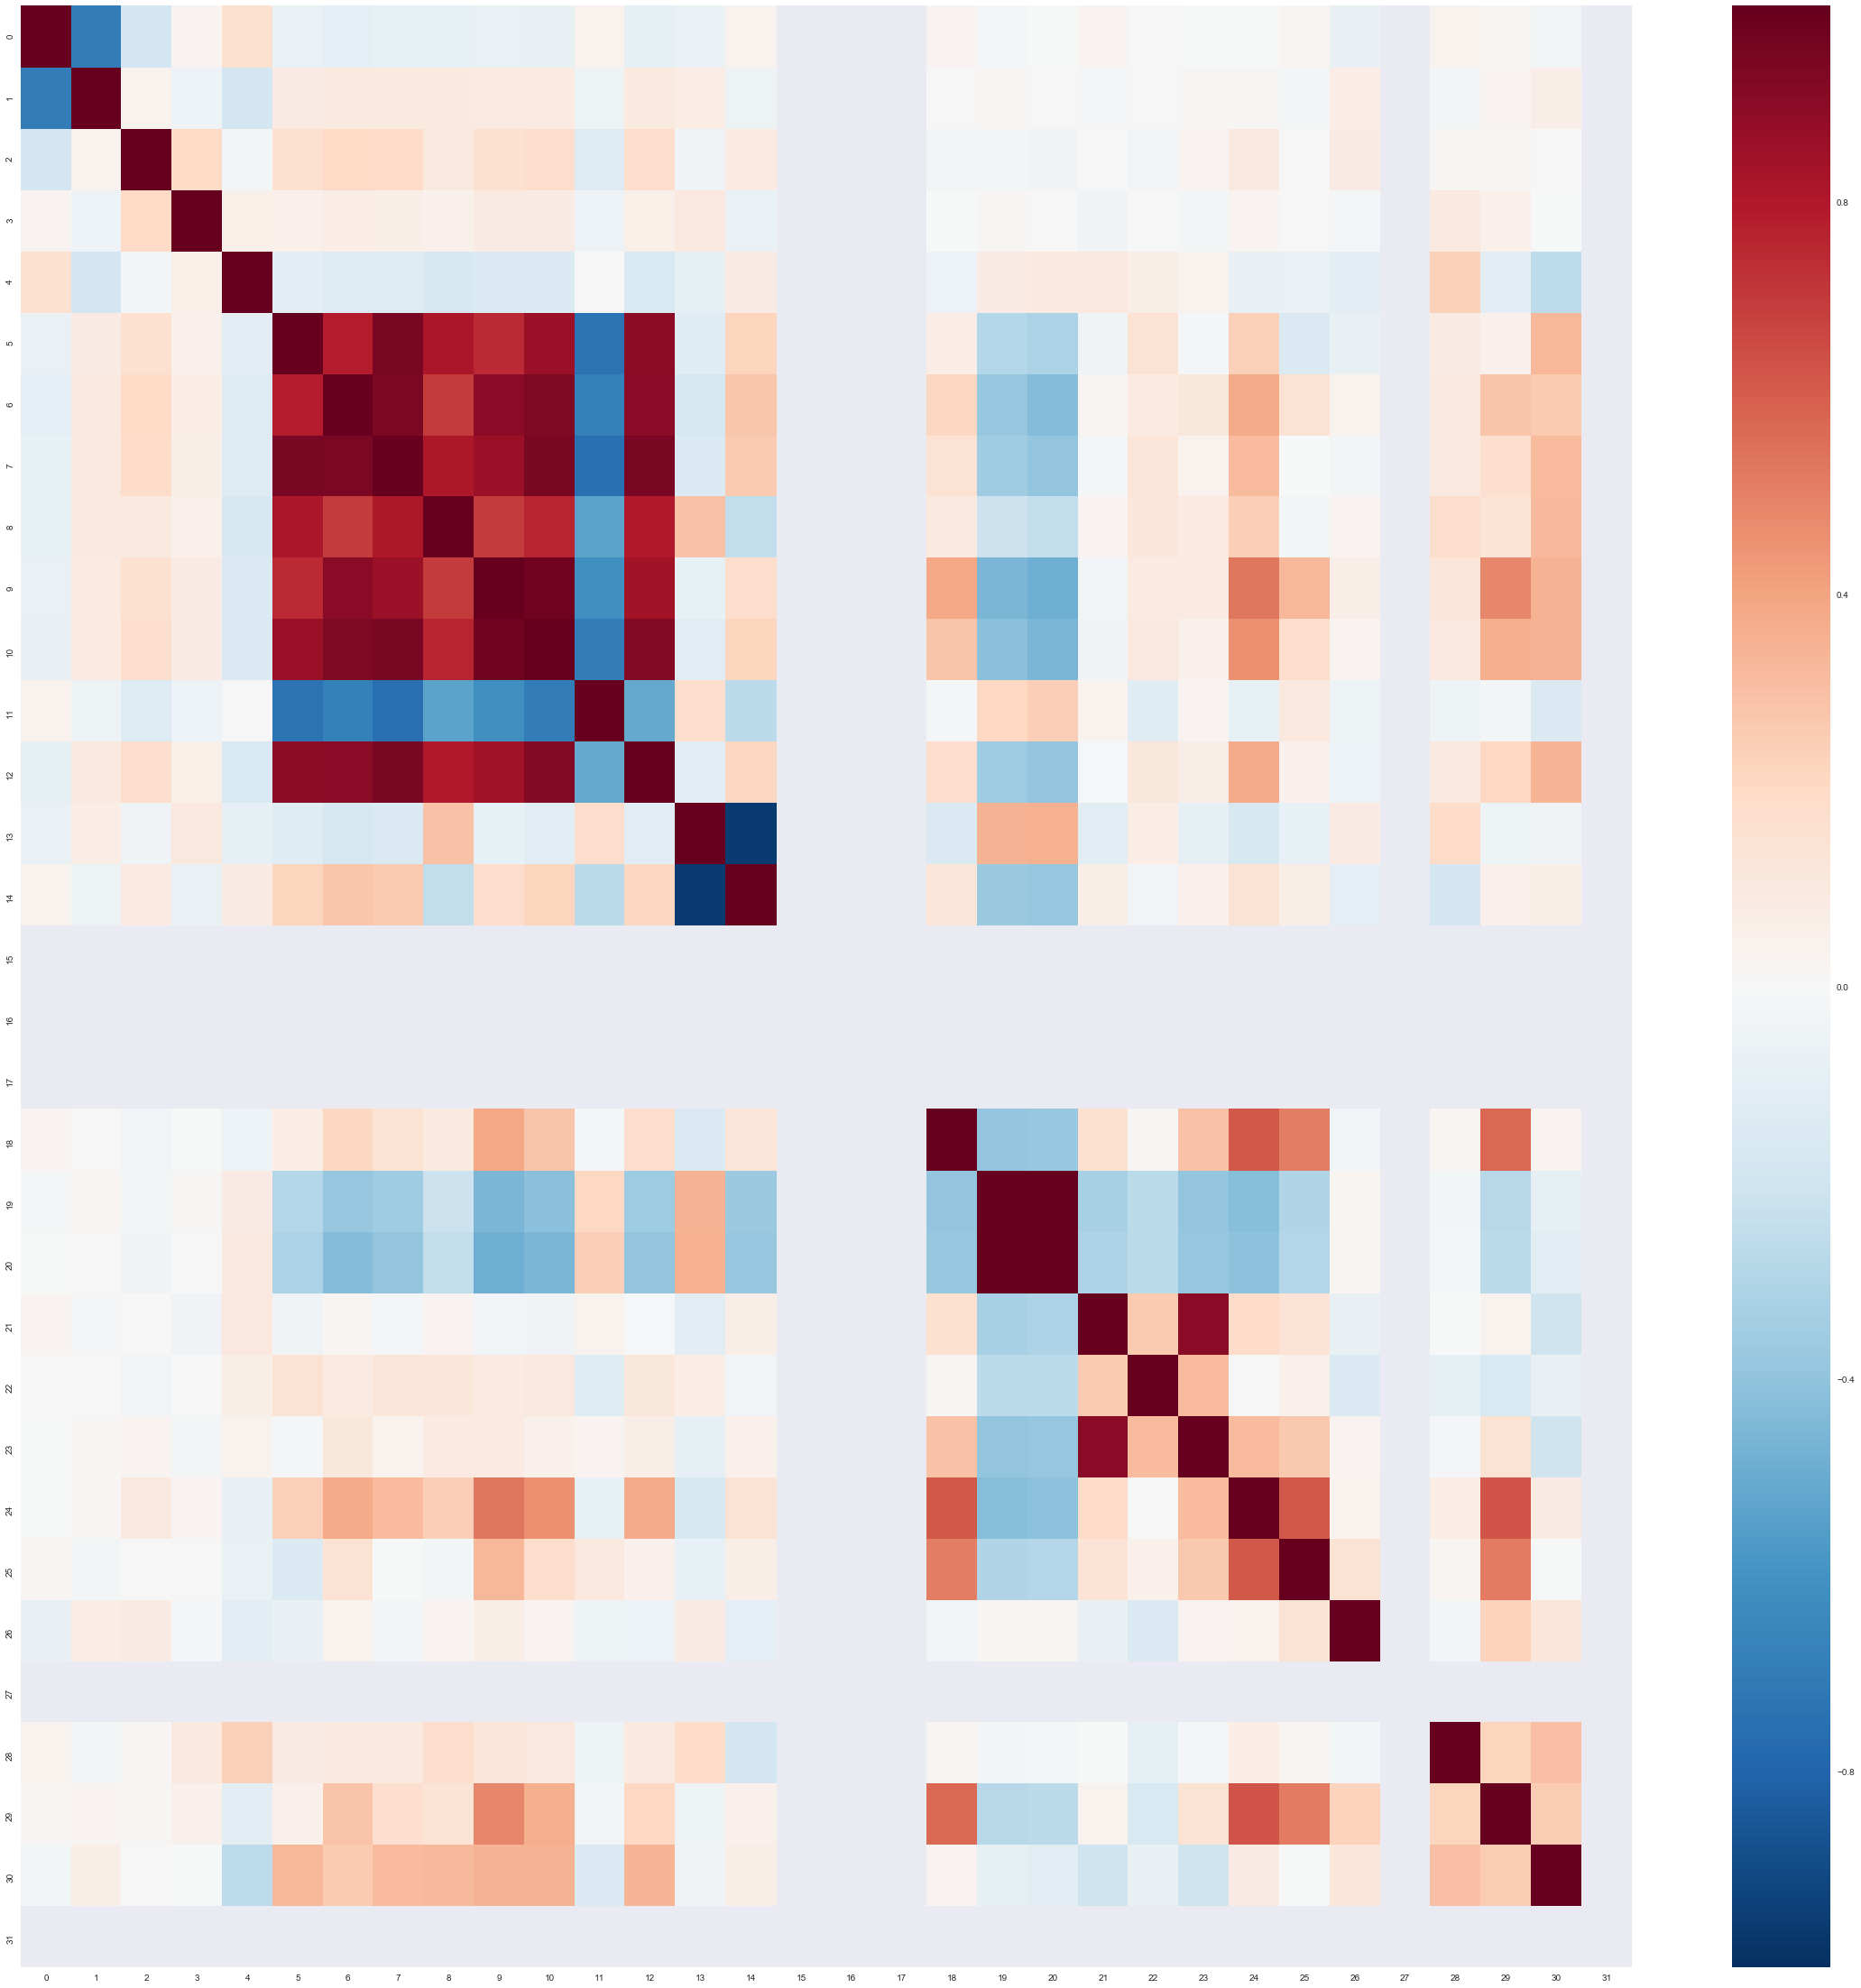

In [466]:
pd.set_option('display.max_columns', 34)
pd.set_option('display.max_rows', 34)

plt.figure(figsize=(40, 40))
sns.heatmap(scaled.corr())

In [215]:
weather[weather['Tavg'] > 82]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
136,1,2007-07-08,94,75,85,12,67,72,0,20,424,1929,,0,0,0.0,0.00,29.05,29.77,12.9,24,13.1,0,0,0,0,0,0,0,0
137,2,2007-07-08,93,75,84,11,67,72,0,19,424,1929,,0,0,0.0,0.00,29.12,29.76,12.6,23,12.7,0,0,0,0,0,0,0,0
139,2,2007-07-09,93,72,83,10,67,71,0,18,425,1929,RA,0,0,0.0,0.24,29.16,29.79,4.8,23,8.8,0,1,0,0,0,0,0,0
197,2,2007-08-07,92,73,83,10,73,76,0,18,451,1904,VCTS,0,0,0.0,0.06,29.11,29.74,6.3,24,8.8,1,0,0,0,0,0,0,0
842,1,2009-06-23,94,71,83,13,69,73,0,18,417,1931,,0,0,0.0,0.00,29.16,29.87,1.8,14,3.5,0,0,0,0,0,0,0,0
843,2,2009-06-23,92,75,84,14,68,73,0,19,417,1931,,0,0,0.0,0.00,29.22,29.85,2.8,13,4.5,0,0,0,0,0,0,0,0
844,1,2009-06-24,94,75,85,14,68,73,0,20,417,1931,TSRA,0,0,0.0,0.04,29.16,29.87,1.9,22,5.8,1,1,0,0,0,0,0,0
845,2,2009-06-24,93,73,83,12,68,73,0,18,417,1931,BR,0,0,0.0,0.78,29.21,29.85,2.1,23,4.3,0,0,0,0,0,1,0,0
846,1,2009-06-25,94,75,85,14,69,73,0,20,417,1931,,0,0,0.0,0.05,29.08,29.80,2.4,32,4.9,0,0,0,0,0,0,0,0
847,2,2009-06-25,93,76,85,14,68,73,0,20,417,1931,,0,0,0.0,0.00,29.15,29.77,1.8,26,4.6,0,0,0,0,0,0,0,0


In [197]:
training_data

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0


In [174]:
print(testing_data['Address'][0])
print(testing_data['Address'][1])

4100 North Oak Park Avenue, Chicago, IL 60634, USA
4100 North Oak Park Avenue, Chicago, IL 60634, USA


In [193]:
training_data[training_data['NumMosquitos'] > 1]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
11,2007-05-29,"2200 North Cannon Drive, Chicago, IL 60614, USA",CULEX PIPIENS/RESTUANS,22,N CANNON DR,T054,"2200 N CANNON DR, Chicago, IL",41.921965,-87.632085,8,2,0
12,2007-05-29,"2200 North Cannon Drive, Chicago, IL 60614, USA",CULEX RESTUANS,22,N CANNON DR,T054,"2200 N CANNON DR, Chicago, IL",41.921965,-87.632085,8,3,0
16,2007-05-29,"1700 West 95th Street, Chicago, IL 60643, USA",CULEX RESTUANS,17,W 95TH ST,T094,"1700 W 95TH ST, Chicago, IL",41.720848,-87.666014,9,3,0
17,2007-05-29,"2200 West 89th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 89TH ST,T096,"2200 W 89TH ST, Chicago, IL",41.731922,-87.677512,8,5,0
20,2007-05-29,"North Streeter Drive, Chicago, IL 60611, USA",CULEX RESTUANS,53,N STREETER DR,T129,"5300 N STREETER DR, Chicago, IL",41.891126,-87.611560,5,2,0
25,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,3,0
26,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,5,0


In [192]:
training_data[(training_data['Species'] == 'CULEX RESTUANS') & (training_data['WnvPresent'] == 1)]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
1599,2007-08-07,"1100 North Artesian Avenue, Chicago, IL 60622,...",CULEX RESTUANS,11,S ARTESIAN AVE,T160,"1100 S ARTESIAN AVE, Chicago, IL",41.903002,-87.688267,8,1,1
1788,2007-08-15,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,1
1791,2007-08-15,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,1
1802,2007-08-15,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,1
1955,2007-08-15,"3000 South Hoyne Avenue, Chicago, IL 60608, USA",CULEX RESTUANS,30,S HOYNE AVE,T035,"3000 S HOYNE AVE, Chicago, IL",41.836644,-87.677737,8,1,1
2367,2007-08-21,"5200 South Kolmar Avenue, Chicago, IL 60632, USA",CULEX RESTUANS,52,S KOLMAR,T114,"5200 S KOLMAR, Chicago, IL",41.798697,-87.736812,8,1,1
5009,2009-07-27,"3300 West 104th Street, Chicago, IL 60655, USA",CULEX RESTUANS,33,W 104TH ST,T095,"3300 W 104TH ST, Chicago, IL",41.704336,-87.703736,8,8,1
5376,2009-08-13,"1100 North Artesian Avenue, Chicago, IL 60622,...",CULEX RESTUANS,11,S ARTESIAN AVE,T160,"1100 S ARTESIAN AVE, Chicago, IL",41.903002,-87.688267,8,1,1
5510,2009-08-25,"Ohare Court, Bensenville, IL 60106, USA",CULEX RESTUANS,10,W OHARE,T903,"1000 W OHARE, Chicago, IL",41.957799,-87.930995,5,14,1
5624,2009-09-03,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,5,1


In [177]:
training_data['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [170]:
spray

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995


In [195]:
training_data.loc[training_data['Date'] == '2007-05-29', 'NumMosquitos'].sum()

40

In [201]:
for date in pd.unique(training_data['Date']):
    print(date,
          ':',
          training_data.loc[training_data['Date'] == date, 'NumMosquitos'].sum(),
          ':',
          training_data.loc[training_data['Date'] == date, 'WnvPresent'].sum())

2007-05-29 : 40 : 0
2007-06-05 : 127 : 0
2007-06-26 : 216 : 0
2007-06-29 : 85 : 0
2007-07-02 : 240 : 0
2007-07-11 : 1103 : 0
2007-07-18 : 853 : 1
2007-07-19 : 687 : 0
2007-07-25 : 4069 : 5
2007-07-27 : 247 : 0
2007-08-01 : 6904 : 18
2007-08-02 : 2898 : 3
2007-08-03 : 204 : 0
2007-08-07 : 1780 : 12
2007-08-08 : 4186 : 7
2007-08-09 : 507 : 1
2007-08-15 : 4661 : 37
2007-08-16 : 4555 : 16
2007-08-17 : 1915 : 7
2007-08-21 : 1667 : 32
2007-08-22 : 4512 : 33
2007-08-24 : 1478 : 25
2007-08-28 : 4748 : 9
2007-09-04 : 524 : 8
2007-09-05 : 2021 : 10
2007-09-06 : 1511 : 2
2007-09-12 : 1193 : 5
2007-09-18 : 392 : 0
2007-09-19 : 1756 : 1
2007-09-24 : 1570 : 2
2007-09-25 : 333 : 0
2007-10-04 : 1373 : 2
2007-10-09 : 333 : 0
2009-05-28 : 190 : 0
2009-06-02 : 663 : 0
2009-06-03 : 348 : 0
2009-06-05 : 257 : 0
2009-06-12 : 1204 : 0
2009-06-15 : 345 : 0
2009-06-19 : 701 : 0
2009-06-22 : 2171 : 0
2009-06-26 : 798 : 0
2009-06-29 : 903 : 0
2009-07-06 : 719 : 0
2009-07-10 : 996 : 0
2009-07-13 : 1369 : 0
2009-0

In [205]:
weather[weather['Date'] == '2013-08-08']

,Unnamed: 0,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
2406,2406,1,2013-08-08,78,65,72,-1,56,62,0,7,...,8.6,5,9.3,0,0,0,0,0,0,0,0
2407,2407,2,2013-08-08,79,69,74,1,55,62,0,9,...,10.5,5,10.8,0,0,0,0,0,0,0,0


In [204]:
weather = pd.read_csv('../assets/input/clean_weather.csv')

In [251]:
df = pd.read_csv('../assets/input/with_coefs.csv')

In [252]:
df

,Unnamed: 0,date,lat,long,address,count,wnv,loc,utc,loc_coef,time_coef
0,0,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"coordinate(lat=41.95469, long=-87.800991)",1180422000,NaN,NaN
1,1,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"coordinate(lat=41.95469, long=-87.800991)",1180422000,NaN,NaN
2,2,2007-05-29,41.994991,-87.769279,"6200 N MANDELL AVE, Chicago, IL",1,0,"coordinate(lat=41.994991, long=-87.769279)",1180422000,NaN,NaN
3,3,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",1,0,"coordinate(lat=41.974089, long=-87.824812)",1180422000,NaN,NaN
4,4,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",4,0,"coordinate(lat=41.974089, long=-87.824812)",1180422000,NaN,NaN
5,5,2007-05-29,41.921600,-87.666455,"1500 W WEBSTER AVE, Chicago, IL",2,0,"coordinate(lat=41.9216, long=-87.666455)",1180422000,NaN,NaN
6,6,2007-05-29,41.891118,-87.654491,"2500 W GRAND AVE, Chicago, IL",1,0,"coordinate(lat=41.891118, long=-87.65449100000...",1180422000,NaN,NaN
7,7,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",1,0,"coordinate(lat=41.867108, long=-87.654224)",1180422000,NaN,NaN
8,8,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",2,0,"coordinate(lat=41.867108, long=-87.654224)",1180422000,NaN,NaN
9,9,2007-05-29,41.896282,-87.655232,"1100 W CHICAGO, Chicago, IL",1,0,"coordinate(lat=41.896282, long=-87.655232)",1180422000,NaN,NaN


In [254]:
df['time_coef'].value_counts()

0.259390    186
0.900250    182
0.445907    181
0.563826    167
0.827988    157
0.662130    153
0.487300    143
0.409654    143
0.206821    139
0.702592    138
0.339740    120
0.069138    112
0.032295    109
0.858149     62
0.802184     50
Name: time_coef, dtype: int64

In [255]:
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Thunderstorm,Rain,Drizzle,Snow,Fog,Mist,Haze,Smoke
0,1,2007-05-01,83,50,67,14,51,56,0,2,448,1849,,0,0,0.0,0.00,29.10,29.82,1.7,27,9.2,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,15,51,57,0,3,448,1849,,0,0,0.0,0.00,29.18,29.82,2.7,25,9.6,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47,14,0,447,1850,BR,0,0,0.0,0.00,29.38,30.09,13.0,4,13.4,0,0,0,0,0,1,0,0
3,2,2007-05-02,60,43,52,-2,42,47,13,0,447,1850,BR HZ,0,0,0.0,0.00,29.44,30.08,13.3,2,13.4,0,0,0,0,0,1,1,0
4,1,2007-05-03,66,46,56,2,40,48,9,0,446,1851,,0,0,0.0,0.00,29.39,30.12,11.7,7,11.9,0,0,0,0,0,0,0,0
5,2,2007-05-03,67,48,58,4,40,50,7,0,446,1851,HZ,0,0,0.0,0.00,29.46,30.12,12.9,6,13.2,0,0,0,0,0,0,1,0
6,1,2007-05-04,66,49,58,4,41,50,7,0,444,1852,RA,0,0,0.0,0.05,29.31,30.05,10.4,8,10.8,0,1,0,0,0,0,0,0
7,2,2007-05-04,78,51,65,11,42,50,0,0,444,1852,,0,0,0.0,0.00,29.36,30.04,10.1,7,10.4,0,0,0,0,0,0,0,0
8,1,2007-05-05,66,53,60,5,38,49,5,0,443,1853,,0,0,0.0,0.05,29.40,30.10,11.7,7,12.0,0,0,0,0,0,0,0,0
9,2,2007-05-05,66,54,60,5,39,50,5,0,443,1853,,0,0,0.0,0.05,29.46,30.09,11.2,7,11.5,0,0,0,0,0,0,0,0


In [264]:
weather['Date'].unique()

1472